In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import scipy.signal
from einops import reduce, rearrange
import numpy as np
import matplotlib.pyplot as plt
from npeet import entropy_estimators as ee
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, ifft
import scipy.signal
from einops import rearrange
from scipy import stats
import skimage
import jax
from jax import vmap
import jax.numpy as jnp

In [2]:
participant_data = scipy.io.loadmat(f'data/matlabPREPROCESSED/s01.mat')
signal_data = torch.FloatTensor(participant_data['data'][:,:32,128*3:])

In [30]:
# Input: Video with shape (32,7680)
# Output: Graph node features with shape (5*32, 59) -> 5 graphs with 32 nodes each with 59 features each
# @vmap
def process_video(video, feature='psd'):
#     print(video.shape)
    assert feature in ['psd', 'de']
    # Transform to frequency domain
    fft_vals = np.fft.rfft(video, axis=-1)
     # Get frequencies for amplitudes in Hz
    samplingFrequency = 128
    fft_freq = np.fft.rfftfreq(video.shape[-1], 1.0/samplingFrequency)
    # Delta, Theta, Alpha, Beta, Gamma
    bands = [(0,4),(4,8),(8,12),(12,30),(30,45)]
    band_data = []
    for f,t in bands:
            mask = np.logical_or(fft_freq < f, fft_freq > t)
            band = np.array(fft_vals) # Copy
#             print(band)
            band[:,mask] = 0
#             jax.ops.index_update(band,mask,0)
#             jax.ops
            band_data.append(band)
    # (5, 32, 7680)
    band_data = np.array(band_data)
    band_data = np.fft.irfft(band_data)

    windows = skimage.util.view_as_windows(band_data, (5,32,256), step=128).squeeze()
    # (5, 32, 59, 256)
    windows = rearrange(windows, 'a b c d -> b c a d')
    
    if feature == 'psd':
        features = scipy.signal.periodogram(windows)[1]
        features = np.mean(features, axis=-1)
    
    features = rearrange(features, 'a b c -> (a b) c')
    features = torch.FloatTensor(features)
#     a= ee.entropy(inv[idx:idx+256].reshape(-1,1), k=2)
    return features

In [31]:
%%time
for video in signal_data[:10]:
    process_video(video)

CPU times: user 461 ms, sys: 76.3 ms, total: 538 ms
Wall time: 537 ms


In [ ]:
process_video(video).shape

/home/carlos/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


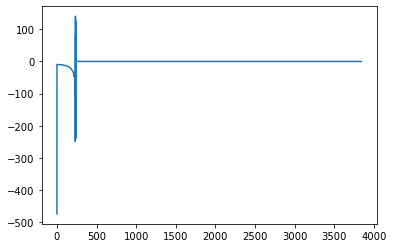

/home/carlos/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


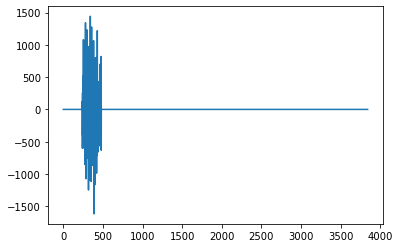

/home/carlos/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


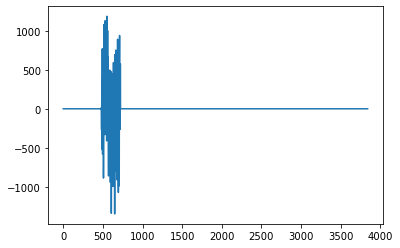

/home/carlos/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


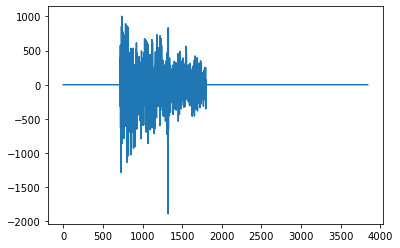

/home/carlos/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


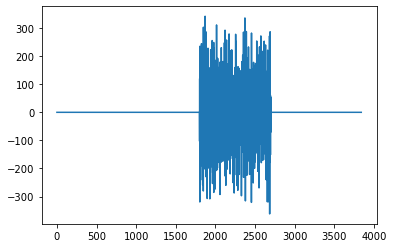

tensor([[0.2517, 0.0892, 0.0666,  ..., 0.0381, 0.0165, 0.1070],
        [0.2324, 0.0726, 0.0437,  ..., 0.0677, 0.0411, 0.2335],
        [0.0894, 0.0246, 0.0126,  ..., 0.1135, 0.0914, 0.2531],
        ...,
        [2.3322, 1.8812, 1.9430,  ..., 1.7668, 1.4776, 1.9406],
        [1.6388, 1.7126, 1.9564,  ..., 2.4412, 1.9744, 1.6760],
        [2.6755, 2.7527, 2.1555,  ..., 3.3251, 3.9143, 3.8308]])

In [29]:
process_video(video)

In [ ]:
vfunc = np.vectorize(process_video)

In [ ]:
%%time
for video in signal_data[:10]:
    vfunc(video)
#     print(video.shape)

In [ ]:
process_video(video)

In [ ]:
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from Electrodes import Electrodes
from tqdm import tqdm
class DEAPDatasetEEGFeatures(InMemoryDataset):
    
  def __init__(self, root, raw_dir,processed_dir,feature='psd', transform=None, pre_transform=None,include_edge_attr = False, undirected_graphs = True, add_global_connections=True, participant_from=1, participant_to=32,window_size=128, n_videos=40):
      self._raw_dir = raw_dir
      self._processed_dir = processed_dir
      self.participant_from = participant_from
      self.participant_to = participant_to
      self.n_videos = n_videos
      self.window_size = window_size
      self.feature = feature
      # Whether or not to include edge_attr in the dataset
      self.include_edge_attr = include_edge_attr
      # If true there will be 1024 links as opposed to 528
      self.undirected_graphs = undirected_graphs
      # Instantiate class to handle electrode positions
      print('Using global connections' if add_global_connections else 'Not using global connections')
      self.electrodes = Electrodes(add_global_connections, expand_3d = False)
      super(DEAPDatasetEEGFeatures, self).__init__(root, transform, pre_transform)
      self.data, self.slices = torch.load(self.processed_paths[0])
      

  @property
  def raw_dir(self):
      return f'{self.root}/{self._raw_dir}'

  @property
  def processed_dir(self):
      return f'{self.root}/{self._processed_dir}'

  @property
  def raw_file_names(self):
      raw_names = [f for f in os.listdir(self.raw_dir)]
      raw_names.sort()
      return raw_names

  @property
  def processed_file_names(self):
      if not os.path.exists(self.processed_dir):
        os.makedirs(self.processed_dir)
      file_name = f'{self.participant_from}-{self.participant_to}' if self.participant_from is not self.participant_to else f'{self.participant_from}'
      return [f'deap_processed_graph.{file_name}_{self.feature}.dataset']

  def process(self):
        # Number of nodes per graph
        n_nodes = len(self.electrodes.positions_3d)

        if self.undirected_graphs:
            source_nodes, target_nodes = np.repeat(np.arange(0,n_nodes),n_nodes), np.tile(np.arange(0,n_nodes),n_nodes)
        else:
            source_nodes, target_nodes = np.tril_indices(n_nodes,n_nodes)
        
        edge_attr = self.electrodes.adjacency_matrix[source_nodes,target_nodes]
        
        # Remove zero weight links
        mask = np.ma.masked_not_equal(edge_attr, 0).mask
        edge_attr,source_nodes,target_nodes = edge_attr[mask], source_nodes[mask], target_nodes[mask]

        edge_attr, edge_index = torch.FloatTensor(edge_attr), torch.tensor([source_nodes,target_nodes], dtype=torch.long)
        
        # Expand edge_index and edge_attr to match windows
        e_edge_index = edge_index.clone()
        e_edge_attr = edge_attr.clone()
        for i in range(58):
            a = edge_index + e_edge_index.max() + 1
            e_edge_index = torch.cat([e_edge_index,a],dim=1)
            e_edge_attr = torch.cat([e_edge_attr,edge_attr],dim=0)

        print(e_edge_index)
        # List of graphs that will be written to file
        data_list = []
        pbar = tqdm(range(self.participant_from,self.participant_to+1))
        for participant_id in pbar:
            raw_name = [e for e in self.raw_file_names if str(participant_id).zfill(2) in e][0]
            pbar.set_description(raw_name)
            # Load raw file as np array
            participant_data = scipy.io.loadmat(f'{self.raw_dir}/{raw_name}')
            signal_data = torch.FloatTensor(participant_data['data'][:,:32,128*3:])
            processed = []
            for i, video in enumerate(signal_data[:self.n_videos,:,:]):
                
                # Differential entropy for each band
                # node_features = process_video_de(video)

                # Power spectral density for each channel
                # node_features = scipy.signal.periodogram(video)[1]
                node_features = process_video(video, feature=self.feature)
                
                # Raw signals 
                # node_features = video
                
                # Should we add MinMax/Z scaler?
                data = Data(x=torch.FloatTensor(node_features),edge_attr=e_edge_attr,edge_index=e_edge_index, y=torch.FloatTensor([participant_data['labels'][i]])) if self.include_edge_attr else Data(x=torch.FloatTensor(node_features), edge_index=e_edge_index, y=torch.FloatTensor([participant_data['labels'][i]]))
                data_list.append(data) 
               
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

# dataset = DEAPDatasetEEGFeatures(root= ROOT_DIR, raw_dir= RAW_DIR, processed_dir= PROCESSED_DIR, feature='de')
# Subject-independent classificati
# DEPENDING ON WHAT DATA IS USED THE NETWORK LEARNS BETTER OR WORSE.
# SHOULD WE TRY TO HAVE A BALANCEd TRAINING SET?
# dataset = dataset.shuffle()
# dataset[0]

In [ ]:
# 880 used for training, 220 validation and 180 testing
splt_idx = 1100
# splt_idx = 35

# 85% used for train/val
train_dataset = dataset[:splt_idx]
test_dataset = dataset[splt_idx:]

train_dataset,test_dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [ ]:
train_dataset[0]

In [ ]:

from torch_geometric.nn import GCNConv
class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=128):
        super(Model, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.gconv1 = GCNConv(in_channels, 256, aggr='add')
        self.gconv2 = GCNConv(256, 128, aggr='add')
        self.gconv3 = GCNConv(128, self.hidden_channels, aggr='add')
        
        self.conv1 = nn.Conv1d(32*self.hidden_channels, 256, 1, stride=1)
        self.conv2 = nn.Conv1d(256, 8, 1, stride=1)
        
        self.lin1 = nn.Linear(59*8,32)
        self.lin2 = nn.Linear(32,1)
#         self.lin3 = nn.Linear(32,1)
        
    def forward(self, batch):
        bs = len(torch.unique(batch.batch))
        x, edge_index = batch.x, batch.edge_index
        

#         x = x.reshape(-1,self.in_channels)
#         print(x.shape)
        x = self.gconv1(x, edge_index)
#         x = torch.tanh(x)
#         x = F.dropout(x, p=0.1, training=self.training)
#         print(x.shape)
#         raise 'err'
        x = self.gconv2(x, edge_index)
#         x = torch.tanh(x)
        x = self.gconv3(x, edge_index)
#         x = torch.tanh(x)
#         x = x.reshape(bs,-1,32)
        # batch size, graph, electrode, features
        x = rearrange(x, '(b g e) f -> b (e f) g', b=bs, e=32)

        
        x = F.dropout(x, p=0.1, training=self.training)
#         print(x.shape)
#         x = x.reshape(bs,-1,32)



        x = self.conv1(x)
        x = torch.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x)
        x = torch.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = x.reshape(bs,-1)


        x = self.lin1(x)
        x.relu()
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.lin2(x)
#         x.sigmoid()
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.lin3(x)
        x = x.view(-1)
        x = x.sigmoid()
#         print(x)
#         x = x*10
        return x

In [ ]:
# %%timeit


model = Model(train_dataset[0].x.shape[1])     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

model = model.to(device)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=.1, rho=0.9, eps=1e-06, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-1, weight_decay=1e-3)
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-2)
# optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3, lr_decay=1e-5, weight_decay=1e-2)

# Instantiate optimizer
# scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()



def train(loader, target = 0):
    model.train()
    losses = []
    right = 0
    tot = 0
    for batch in loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        y = (batch.y[:,target] > 5).float()
        out = model(batch)
        loss = criterion(out,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        right += torch.eq(out > .5, y > .5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

def test(loader,verbose=False, target = 0):
    model.eval()
    losses = []
    right = 0
    tot = 0
    for batch in loader:
        batch = batch.to(device)
        y = (batch.y[:,target] > 5).float()
        out = model(batch)
        if verbose:
            print(out,y)
        loss = criterion(out,y)
        losses.append(loss.item())
        right += torch.eq(out > .5, y > .5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

best_val_loss = np.inf
esp = 0
MAX_ESP = 20

BS = 4

k_folds = 5
k_fold_size = len(train_dataset)/k_folds
current_fold = 0 # Ranges from 0 to k_folds-1

target = 1 # Valence-Arousal-Dominance-Liking
for epoch in range(1, 10000):    
    # KFOLD train/val split     
#     if epoch %1 == 0:
#         current_fold = current_fold+1 if current_fold < k_folds-1 else 0
    from_idx, to_idx = int(k_fold_size*current_fold), int(k_fold_size*(current_fold+1))
    kf_val_data = train_dataset[from_idx:to_idx]
    a = train_dataset[:from_idx]
    b = train_dataset[to_idx:]
    kf_train_data = a + b
    train_loader = DataLoader(kf_train_data, batch_size=BS, shuffle=False)
    val_loader = DataLoader(kf_val_data, batch_size=BS)
        
    # Training and validation
    train_loss, train_acc = train(train_loader, target = target)
    val_loss, val_acc = test(val_loader , target = target)
    print(f'Epoch {epoch} - Kfold:{current_fold} ;t loss: {train_loss:.5f} ;t acc: {train_acc:.2f} ;v loss: {val_loss:.5f} ;v acc: {val_acc:.2f}')

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        esp = 0
        torch.save(model.state_dict(),'./best_params') 
    else:
        esp += 1
        if esp >= MAX_ESP:
            break
            
    if epoch % 20 == 0:
        test_loader = DataLoader(test_dataset, batch_size=1)
        loss, acc = test(test_loader, True)
        print(f'Test loss: {loss} ; Test acc: {acc}')
        
#     scheduler.step()


print('Finished training')

In [ ]:
model.load_state_dict(torch.load('./best_params'))
test_loader = DataLoader(test_dataset, batch_size=1)
loss, acc = test(train_loader, False,target=target)
print(f'Train loss: {loss} ; Train acc: {acc}')
loss, acc = test(val_loader, False,target=target)

print(f'Val loss: {loss} ; Val acc: {acc}')
loss, acc = test(test_loader, True,target=target)
print(f'Test loss: {loss} ; Test acc: {acc}')

# TODO: scheduler(?) Loss/acc records